In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [29]:
stock1=input("Pls enter the stock: ")
Start_Date=input("Pls enter the start_date: ")
End_Date=input("Pls enter the End_Date: ")
data=yf.download(stock1,Start_Date,End_Date)
print(data)

Pls enter the stock: TSLA.NE
Pls enter the start_date: 2010-01-01
Pls enter the End_Date: 2022-01-01
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2021-08-11  23.160000  23.160000  22.959999  22.980000  22.980000    2214
2021-08-12  22.920000  23.450001  22.820000  23.340000  23.340000    6248
2021-08-13  23.500000  23.500000  23.230000  23.309999  23.309999    2123
2021-08-16  22.920000  22.920000  22.070000  22.190001  22.190001    9687
2021-08-17  21.840000  21.889999  21.150000  21.620001  21.620001   16115
...               ...        ...        ...        ...        ...     ...
2021-12-23  32.540001  34.619999  32.299999  34.480000  34.480000  210922
2021-12-24  34.750000  35.750000  34.750000  34.869999  34.869999   21504
2021-12-29  35.540001  35.580002  34.439999  35.090000  35.090000  166449
2021-12-30  34.2

In [30]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df
stock_macd = get_macd(data['Close'],26,12,9)
stock_macd.tail()

,macd,signal,hist
Date,,,
2021-12-23,-0.673371,-0.697376,0.024006
2021-12-24,-0.396760,-0.637253,0.240493
2021-12-29,-0.157971,-0.541397,0.383426
2021-12-30,-0.013758,-0.435869,0.422111
2021-12-31,0.066680,-0.335359,0.402039


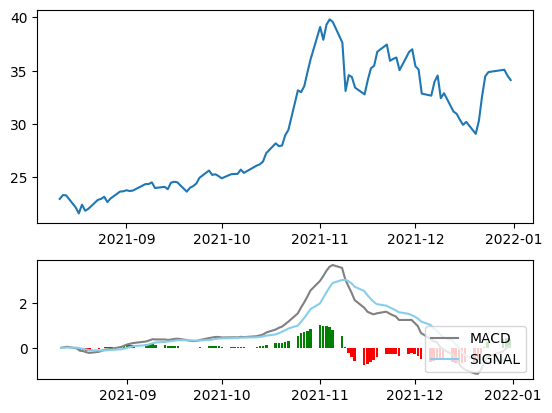

In [31]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((12,3), (0,0), rowspan = 7, colspan = 5)
    ax2 = plt.subplot2grid((12,3), (8,0), rowspan = 6, colspan = 5)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = 'red')
        else:
            ax2.bar(prices.index[i], hist[i], color = 'green')

    plt.legend(loc = 'lower right')
plot_macd(data['Close'], stock_macd['macd'], stock_macd['signal'], stock_macd['hist'])

In [32]:
def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(data['Close'], stock_macd)

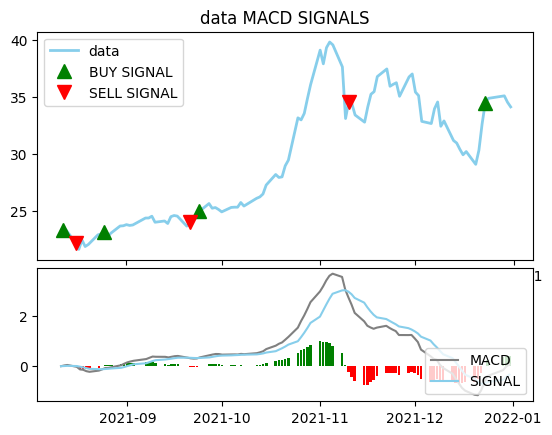

In [33]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(data['Close'], color = 'skyblue', linewidth = 2, label = 'data')
ax1.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('data MACD SIGNALS')
ax2.plot(stock_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(stock_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(stock_macd)):
    if str(stock_macd['hist'][i])[0] == '-':
        ax2.bar(stock_macd.index[i], stock_macd['hist'][i], color = 'red')
    else:
        ax2.bar(stock_macd.index[i], stock_macd['hist'][i], color = 'green')

plt.legend(loc = 'lower right')
plt.show()

In [34]:
position = []

if(macd_signal[0]==1):
    position.append(1)
else:
    position.append(0)

for i in range(1,len(data['Close'])):
    if macd_signal[i] == 1:
        position.append(1)
    elif macd_signal[i] == -1:
        position.append(0)
    else:
        position.append(position[i-1])

macd = stock_macd['macd']
signal = stock_macd['signal']
close_price = data['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(data.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(data.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,macd,signal,macd_signal,macd_position
Date,,,,,
2021-08-11,22.980000,0.000000,0.000000,0,0
2021-08-12,23.340000,0.028718,0.005744,1,1
2021-08-13,23.309999,0.048497,0.014294,0,1
2021-08-16,22.190001,-0.025903,0.006255,-1,0
2021-08-17,21.620001,-0.129369,-0.020870,0,0
...,...,...,...,...,...
2021-12-23,34.480000,-0.673371,-0.697376,1,1
2021-12-24,34.869999,-0.396760,-0.637253,0,1
2021-12-29,35.090000,-0.157971,-0.541397,0,1


In [43]:
buy_dates = strategy[strategy['macd_signal'] == 1].index

# Get dates of sell signals
sell_dates = strategy[strategy['macd_signal'] == -1].index

print("Buy Dates:")
print(buy_dates)

print("\nSell Dates:")
print(sell_dates)

Buy Dates:
DatetimeIndex(['2021-08-12', '2021-08-25', '2021-09-24', '2021-12-23'], dtype='datetime64[ns]', name='Date', freq=None)

Sell Dates:
DatetimeIndex(['2021-08-16', '2021-09-21', '2021-11-10'], dtype='datetime64[ns]', name='Date', freq=None)


In [44]:
from math import floor
from termcolor import colored as cl
stock_ret = np.abs(np.diff(data['Close']))
macd_strategy_ret = []
returns=()
for i in range(len(stock_ret)):
    try:
        returns = stock_ret[i]*strategy['macd_position'][i]
        std_dev = np.std(returns)
        macd_strategy_ret.append(returns)
    except:
        pass


investment_value = 100000
number_of_stocks = floor(investment_value/data['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret)):
    returns = number_of_stocks*macd_strategy_ret[i]
    macd_investment_ret.append(returns)
    print(macd_investment_ret)
    print(number_of_stocks)

total_investment_ret = round(sum(macd_investment_ret), 2)

profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing 100k in TESLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))
df = pd.DataFrame({'PNL':macd_strategy_ret })
print(df)

[0.0]
4351
[0.0, 130.5329875946045]
4351
[0.0, 130.5329875946045, 4873.115352630615]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2175.5]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2175.5, 1479.340663909912]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2175.5, 1479.340663909912, 2828.1483402252197]
4351
[0.0, 130.5329875946045, 4873.115352630615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2175.5, 1479.3

In [40]:
import numpy as np
# Calculate average daily return and standard deviation of daily returns
avg_daily_return = np.mean(macd_strategy_ret)
std_dev_daily_return = np.std(macd_strategy_ret)

# Replace with your desired risk-free rate
risk_free_rate = 0.02  # For example, 2% annual risk-free rate

# Calculate Sharpe ratio
sharpe_ratio = (avg_daily_return - risk_free_rate) / std_dev_daily_return

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")



Sharpe Ratio: 0.4845
